## Introduction
In this notebook we will preprocess the data for the cardiac detection task.
We provide bounding boxes for around 500 images of the RSNA pneumonia detection challenge dataset which you have already downloaded in the last section. 

We will convert the images to npy files for efficient storage and faster data loading.

## Imports

* pathlib for easy path handling
* pydicom for reading dicom files
* numpy for storing the actual images
* cv2 for directly resizing the images
* pandas to read the provided labels
* matplotlib for visualization
* patches from matplotlib to draw bounding boxes

In [6]:
from pathlib import Path # Object-oriented filesystem path manipulation
import numpy as np # Fundamental package for numerical computing, especially array operations
import cv2 # Computer vision library for image processing and visualisation
import pandas as pd # Data manipulation and analysis, primarily with DataFrames
from torchvision.models import ResNet18_Weights # Pre-trained weights for the ResNet18 model
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping # Callbacks for saving models and stopping training early
import matplotlib.pyplot as plt # Plotting library for creating visualisations
import matplotlib.patches as patches # Used to draw shapes like rectangles on plots
import torch # Main PyTorch library for deep learning
import torch.nn as nn
import imgaug # Core library for image augmentation
import pydicom # Library for working with DICOM files
from imgaug.augmentables.bbs import BoundingBox # Object for defining bounding boxes in image augmentation
import tensorflow as tf # Deep learning framework (often for comparison or specific tools)
import torchvision # Contains models, datasets, and transformations for computer vision
import pytorch_lightning as pl # High-level framework for training PyTorch models
from pytorch_lightning.loggers import TensorBoardLogger # Logger for TensorBoard integration
import imgaug.augmenters as iaa # Specific submodule for defining augmentation sequences
from dataset import CardiacDataset # Custom class for loading and preparing cardiac image data

At first, we read the csv file containing the labels.

In [2]:
labels = pd.read_csv(r"D:\Projects D\Cardiac\rsna_heart_detection - D.csv")

In [3]:
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [4]:
ROOT_PATH = Path(r"D:\Projects D\Pneumonia Data\stage_2_train_images", )
SAVE_PATH = Path(r"C:\Users\User\Desktop\Processed Data\Cardiac Processed")

Let's visualize some images with corresponding bounding boxes around the heart


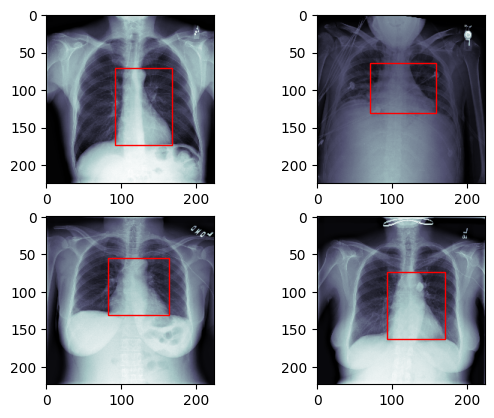

In [7]:


# Assuming ROOT_PATH and labels are defined somewhere
# For example:
# ROOT_PATH = Path('/path/to/your/dicom/files')
# labels = pd.read_csv('your_labels.csv')

fig, axis = plt.subplots(2, 2)
c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        patient_id = data["name"]
        dcm_path = ROOT_PATH/str(patient_id)
        dcm_path = dcm_path.with_suffix(".dcm")

        # Read the DICOM file and get the pixel array in one step
        dcm_array = pydicom.dcmread(dcm_path).pixel_array

        # Resize the array
        dcm_array = cv2.resize(dcm_array, (224, 224))

        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]

        axis[i][j].imshow(dcm_array, cmap="bone")
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor="r", facecolor='none')
        axis[i][j].add_patch(rect)
        c += 1

plt.show()

Lets do some preprocessing on the data<br />
To be able to distinguish between train and validation subjects, we store them in two lists and later save these lists.

What I did:

CoDe iterates through patient data, using pydicom to read the large, original 1024x1024 DICOM X-ray files and then resizes them down to 224x224 and scales the pixel values to the 0−1 range to drastically improve training speed and stability, to save compute. 

For reproducibility, the first 400 patients are assigned to the training set and the rest to the validation set, and the processed image arrays are saved as NumPy files to avoid repeated processing later.

Finally, the code calculates the running mean and sum of squares exclusively from the training data, which are necessary statistics used for final dataset normalisation (a standard practice to boost model performance) before training begins.

In [18]:
sums = 0
sums_squared = 0
train_ids = []
val_ids = []

for counter, patient_id in enumerate(list(labels.name)):  
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
    
    dcm = pydicom.dcmread(dcm_path)  # Read the dicom file with pydicom
    
     # Retrieve the actual image 
    dcm_array = dcm.pixel_array
    assert dcm_array.shape == (1024, 1024)
    
    # Resize the image to drastically improve training speed
    # In order to reduce the space when storing the image we convert it to float16
    # Standardize to 0-1 range
    dcm_array = (cv2.resize(dcm_array, (224, 224)) / 255).astype(np.float16)
            
    # 4/5 train split, 1/5 val split
    train_or_val = "train" if counter < 400 else "val" 
    
    # Add to corresponding train or validation patient index list
    if train_or_val == "train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)
    
    current_save_path = SAVE_PATH/train_or_val # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    
    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory
    
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
    if train_or_val == "train":  # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer


The variable sums is a running total used to calculate the global mean pixel value of the entire training dataset. This calculation is for data normalisation, a standard machine learning preprocessing step that helps centre the data for faster and stable training.

In [19]:
sums

197.72066326530597

Finally we store the train and val subject ids

In [20]:
np.save(r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Processed-Heart-Detection\train_subjects_det", train_ids)
np.save(r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Processed-Heart-Detection\val_subjects_det", val_ids)

In [21]:
mean = sums / len(train_ids)
std = np.sqrt(sums_squared / len(train_ids) - (mean**2), dtype=np.float64)

These lines finalise the calculation of the global mean (μ) and standard deviation (σ) of the training dataset. This is done because these two statistics are essential for data normalisation, a crucial preprocessing step that ensures the input data has a consistent distribution for faster and more stable deep learning model convergence.

In [22]:
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.49430165816326493, STD: 0.2527964897943661


This command will simply output the final calculated mean (mu) and standard deviation (sigma) of the training dataset to the console. These printed statistics are the essential final product of the previous calculations, and they are required for applying the (x - mu) / sigma normalisation to the image data during the actual model training process.

## DataSet Creation
Now we define the torch dataset!
We need to define a __ len __ function which returns the length of the dataset and a __ getitem __ function which returns the image and corresponding bounding box.

Additionally we apply data augmentation and normalization.

**Important**: Augment bounding box together with image!<br />
You can use *BoundingBox(x1, y1, x2, y2) for that*.<br />
Next you call *self.augment(image=img, bounding_boxes=bb)* which returns the augmented image and bounding boxes<br />
Finally you extract the coordinates from the augmented bbox coordinates. Note that it is a 2D array.
```python
bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
```

In [23]:
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        
        self.labels = pd.read_csv(path_to_labels_csv)
        
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs
        
    def  __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.patients)
        
    def __getitem__(self, idx):
        """
        Returns an image paired with bbox around the heart
        """
        patient = self.patients[idx]
        # Get data according to index
        data = self.labels[self.labels["name"]==patient]
        
        # Get entries of given patient
        # Extract coordinates
        
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()  # get xmax from width
        y_max = y_min + data["h"].item()  # get ymax from height
        bbox = [x_min, y_min, x_max, y_max]


        # Load file and convert to float32
        file_path = self.root_path/patient  # Create the path to the file
        img = np.load(f"{file_path}.npy").astype(np.float32)
        
        
        # Apply imgaug augmentations to image and bounding box
        if self.augment:
            
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            
            ###################IMPORTANT###################
            # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
            # https://github.com/pytorch/pytorch/issues/5059
            random_seed = torch.randint(0, 1000000, (1,)).item()
            imgaug.seed(random_seed)
            #####################################################

            img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
            
            
        # Normalize the image according to the values computed in Preprocessing
        img = (img - 0.494) / 0.252

        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
            
        return img, bbox


In [24]:
# Below augments the data

seq = iaa.Sequential([
            iaa.GammaContrast(), #Adding various contrast
            iaa.Affine(
                scale=(0.8, 1.2), #Changes scale
                rotate=(-10, 10), #Random rotations
                translate_px=(-10, 10)
            )
        ])


This code uses the imgaug package to apply a series of random transformations—specifically, gamma contrast adjustments, scaling, rotation, and translation—to the training images. This is done to artificially increase the size and diversity of the dataset, which helps prevent the model from overfitting and makes it better at recognising the heart despite slight variations in real-world X-rays.

In [25]:
labels_path = r"D:\Projects D\Cardiac\rsna_heart_detection - D.csv"
patients_path = r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Processed-Heart-Detection\train_subjects_det.npy"
train_root = r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\train"
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

This code is initialising a custom PyTorch Dataset called CardiacDataset by providing it with all the necessary file locations and the augmentation pipeline.

It does this to prepare the X-ray data for model consumption: the CardiacDataset will use the paths to find the image file names (labels_path), the processed patient IDs (patients_path), and the location of the NumPy image arrays (train_root), applying the defined augmentation sequence (seq) to each image as it is requested by the model during training.

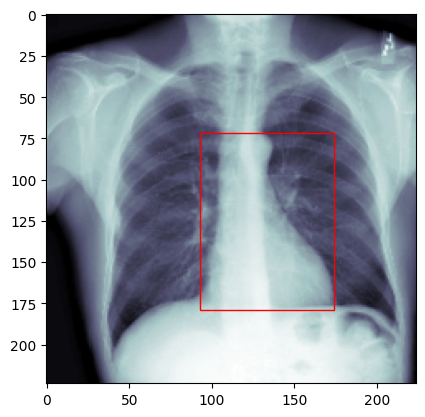

In [28]:
#Creating a bounding box around the heart, despite rotation and scaling
img, bbox = dataset[0]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)

tensor([ 63.0697,  45.7404, 175.5156, 175.9753])


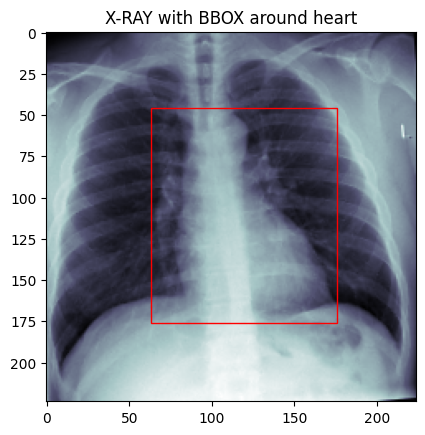

In [29]:
img, label = dataset[17]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
spot1 = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], edgecolor='r', facecolor='none')
axis.add_patch(spot1)

axis.set_title("X-RAY with BBOX around heart")
print(label)

Above code retrieves the 18th image and its associated bounding box label from the prepared CardiacDataset, and plots the X-ray image with the bounding box overlaid, just to check it's working.

Next step is training the model.

The dataset object is like a smart list of all your data that can load images and their labels one by one without overwhelming the computer's memory. The augmentation parameters are a set of rules, like flipping or rotating, that tell the dataset object how to transform the images on the fly to help model learn better.

In [30]:
train_root_path = r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\train"
train_subjects = r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Processed-Heart-Detection\train_subjects_det.npy"
val_root_path = r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\val"
val_subjects = r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Processed-Heart-Detection\val_subjects_det.npy"

train_transforms = iaa.Sequential([
                                iaa.GammaContrast(),
                                iaa.Affine(
                                    scale=(0.8, 1.2),
                                    rotate=(-10, 10),
                                    translate_px=(-10, 10)
                                )
                            ])

In [31]:
train_dataset = CardiacDataset(r"D:\Projects D\Cardiac\rsna_heart_detection - D.csv", train_subjects, train_root_path, train_transforms)
val_dataset = CardiacDataset(r"D:\Projects D\Cardiac\rsna_heart_detection - D.csv", val_subjects, val_root_path, None)

In [32]:
# This code creates two data loaders that efficiently feed data to your model during training and validation.

batch_size = 17 #no images processed together in a single batch. Processing data in batches is more efficient than 1 at a time, especially on GPUs.
num_workers = 3 #no of processes loading data in the background. multiple workers ensures next batch is ready, preventing idle time.

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

## Model Creation

1. 4 outputs: We need to estimate the location of the heart (xmin, ymin, xmax, ymax).
2. Loss function: We are going to use the L2 loss (Mean Squared Error), as we are dealing with continuous values (numbers that range across a spectrum)

In [43]:
class CardiacDetectionModel(pl.LightningModule):
    """
    A PyTorch Lightning model for cardiac detection. It uses a pre-trained
    ResNet18 model and adapts it for single-channel X-ray images. This is
    version 2 with a modified learning rate.
    """
    def __init__(self):
        super().__init__()
        
        # Initializes model with pre-trained ResNet18 weights.
        self.model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Adjusts model's first layer for single-channel grayscale images.
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Changes the output layer to predict 4 values for a bounding box.
        self.model.fc = nn.Linear(in_features=512 ,out_features=4)
        
        # Sets the learning rate to 1e-5 for the optimizer.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-5)
        self.loss_fn = nn.MSELoss()
        
    def forward(self, data):
        """Passes data through the model."""
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        """Performs a single training step."""
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        """Performs a single validation step."""
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)

        # Log the validation loss
        self.log("Val Loss", loss, on_epoch=True)
        
        # You don't need to log 'epoch' separately if you log with 'on_epoch=True'
        # The logger will handle it correctly.

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss

    def log_images(self, x_ray, pred, label, name):
        """Visualizes and logs images with predicted and true bounding boxes."""
        results = []
        
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            
            # Converts image to a visible format.
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            # Draws true bounding box (black).
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            # Draws predicted bounding box (white).
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
        
        grid = torchvision.utils.make_grid(results, 2)
        # Logs the grid of images to a logger like TensorBoard.
        self.logger.experiment.add_image(name, grid, self.global_step)
        
    def configure_optimizers(self):
        """Sets up the optimizer."""
        return [self.optimizer]


In [34]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    # Explicitly set the directory path
    dirpath=r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Weights",
    # Monitors the validation loss
    monitor='Val Loss',
    # Saves when the monitored metric decreases
    mode='min',
    # Keeps only the best model
    save_top_k=1,
    # Naming convention for the file
    filename='{epoch}-{Val Loss:.2f}'
)

# Create the early stopping callback
early_stopping_callback = EarlyStopping(
    # Monitors the validation loss
    monitor='Val Loss',
    # Stops training after 3 epochs if no improvement
    patience=3,
    # Monitors for a decrease in the metric
    mode='min'
)


In [56]:
# Create the model object
model = CardiacDetectionModel()  # Instantiate the model

In [36]:
# Create the trainer
trainer = pl.Trainer(
    accelerator='gpu',
    logger=TensorBoardLogger(r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Logs"),
    log_every_n_steps=1,
    default_root_dir=r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Weights",
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=1000
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
#Train with the new model
trainer.fit(model, train_loader, val_loader)

The model trained, but due to an odd bug it gave a wall of output, so I removed it to make it easier to me. Next we will evaluate the model.

## Evaluation

In [63]:
#Code to print the final Val Loss. The lower the better.

def get_scalar_data_from_tags(log_file, tags_to_extract):
    """
    Extracts scalar data for specific tags from a TensorFlow event file.
    """
    data = {tag: [] for tag in tags_to_extract}
    try:
        for event in tf.compat.v1.train.summary_iterator(log_file):
            for value in event.summary.value:
                if value.tag in tags_to_extract:
                    data[value.tag].append(value.simple_value)
    except Exception as e:
        print(f"Error reading log file: {e}")
        return None
    return data

# Path to Log folder, storing the tensorflow event file which provides information about the training
log_file_path = r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Logs2\lightning_logs\version_1\events.out.tfevents.1758598605.HomePC.35528.4"

# Extract the data for Val Loss
tags_to_extract = ["Val Loss"]
extracted_data = get_scalar_data_from_tags(log_file_path, tags_to_extract)

if extracted_data and "Val Loss" in extracted_data:
    val_losses = extracted_data["Val Loss"]
    if val_losses:
        final_val_loss = val_losses[-1]
        print(f"The final validation loss is: {final_val_loss:.2f}")
    else:
        print("No validation loss data found.")
else:
    print("Failed to extract data.")

The final validation loss is: 11508.86


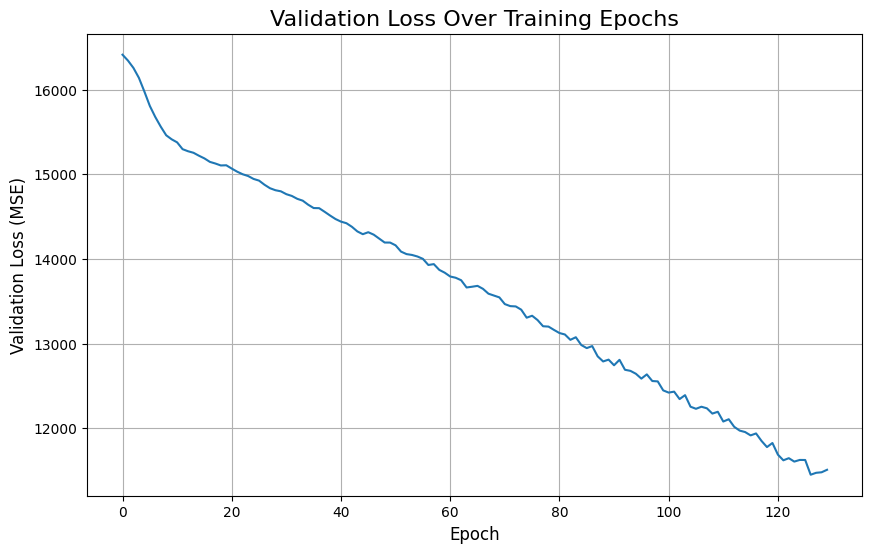

In [ ]:
def get_scalar_data_from_tags(log_file, tags_to_extract):
    """
    Extracts scalar data for specific tags from a TensorFlow event file.
    """
    data = {tag: [] for tag in tags_to_extract}
    try:
        for event in tf.compat.v1.train.summary_iterator(log_file):
            for value in event.summary.value:
                if value.tag in tags_to_extract:
                    data[value.tag].append(value.simple_value)
    except Exception as e:
        print(f"Error reading log file: {e}")
        return None
    return data

# Path to the log file.
log_file_path = r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Logs2\lightning_logs\version_1\events.out.tfevents.1758598605.HomePC.35528.4"

# Extract the data for Val Loss and Epoch
tags_to_extract = ["Val Loss", "epoch"]
extracted_data = get_scalar_data_from_tags(log_file_path, tags_to_extract)

if extracted_data is None or not extracted_data["Val Loss"] or not extracted_data["epoch"]:
    print("No 'Val Loss' or 'epoch' data found. Please check the tags and log file.")
else:
    val_losses = extracted_data["Val Loss"]
    # Here is the fix: create a new list of epochs from 0 to the number of data points
    epochs = list(range(len(val_losses)))

    # Plotting the validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_losses)
    plt.title("Validation Loss Over Training Epochs", fontsize=16)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation Loss (MSE)", fontsize=12)
    plt.grid(True)
    plt.show()

This is a VERY high number, meaning the model is not functioning well. 

The model is putting boxes around areas that are near the heart, but not quite close enough to be useful.

The MSE means that the boxes are missing the correct pixels by a moderate amount.

To improve it I will increase the learning rate, and see if that helps. Lets have a look at examples of the model in action.

Compute prediction for all validation samples

In [53]:
device = torch.device("cuda") 

In [ ]:
"""
Iterates through the validation dataset, makes predictions with the trained model,
and stores the predictions and labels for later evaluation.
"""
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0) # Data goes to the GPU ('cuda')
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)

preds=torch.stack(preds)
labels=torch.stack(labels)

Compute mean deviation between prediction and labels for each coordinate

In [65]:
"""
Calculates the mean absolute error for each bounding box coordinate
by taking the absolute difference between the predicted and true values.
"""
abs(preds-labels).mean(0)

tensor([7.4219, 6.6965, 8.3667, 9.0536])

Example prediction:

tensor([109,  65, 180, 172])


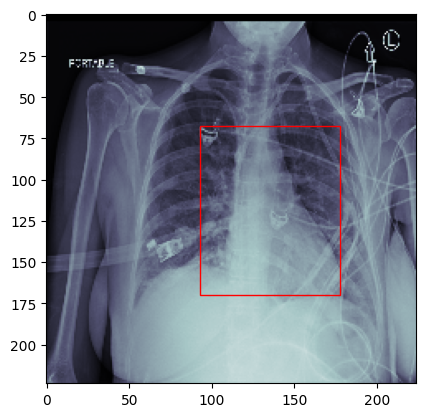

In [66]:
"""
Visualizes the model's prediction on a single image from the validation set,
drawing a bounding box around the predicted location of the heart.
"""
IDX = 16
# Feel free to inspect all validation samples by changing the index
img, label = val_dataset[IDX]
current_pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
heart = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                          current_pred[3]-current_pred[1], linewidth=1, edgecolor='r', facecolor='none')
axis.add_patch(heart)

print(label)

Below I will train a new model with a higher learning rate.

What is Learning Rate?

Hyperparameter controlling how much we adjust the weights of neural networks with respect to loss gradient. In simpler terms, it's the size of the steps you take while walking downhill.

Big Learning Rate: If you take huge steps, you might reach the bottom of the hill faster, but you also risk overshooting the lowest point and ending up on the other side of the valley. This can cause your model's performance to get worse.

Small Learning Rate: If you take tiny, cautious steps, you are more likely to find the absolute lowest point, but it will take you a long time to get there.

In this case, a small LR lead to a high error rate, so let's try the bigger steps down that hill.

In [44]:
class CardiacDetectionModel2(pl.LightningModule):
    """
    A PyTorch Lightning model for cardiac detection. It uses a pre-trained
    ResNet18 model and adapts it for single-channel X-ray images. This is
    version 2 with a modified learning rate.
    """
    def __init__(self):
        super().__init__()
        
        # Initializes model with pre-trained ResNet18 weights.
        self.model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Adjusts model's first layer for single-channel grayscale images.
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Changes the output layer to predict 4 values for a bounding box.
        self.model.fc = nn.Linear(in_features=512 ,out_features=4)
        
        # Sets the learning rate to 1e-4 for the optimizer.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = nn.MSELoss()
        
    def forward(self, data):
        """Passes data through the model."""
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        """Performs a single training step."""
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        """Performs a single validation step."""
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)

        # Log the validation loss
        self.log("Val Loss", loss, on_epoch=True)
        
        # You don't need to log 'epoch' separately if you log with 'on_epoch=True'
        # The logger will handle it correctly.

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss

    def log_images(self, x_ray, pred, label, name):
        """Visualizes and logs images with predicted and true bounding boxes."""
        results = []
        
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            
            # Converts image to a visible format.
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            # Draws true bounding box (black).
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            # Draws predicted bounding box (white).
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
        
        grid = torchvision.utils.make_grid(results, 2)
        # Logs the grid of images to a logger like TensorBoard.
        self.logger.experiment.add_image(name, grid, self.global_step)
        
    def configure_optimizers(self):
        """Sets up the optimizer."""
        return [self.optimizer]

In [45]:


# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    # Explicitly set the directory path
    dirpath=r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Weights2",
    # Monitors the validation loss
    monitor='Val Loss',
    # Saves when the monitored metric decreases
    mode='min',
    # Keeps only the best model
    save_top_k=1,
    # Naming convention for the file
    filename='{epoch}-{Val Loss:.2f}'
)

# Create the early stopping callback
early_stopping_callback = EarlyStopping(
    # Monitors the validation loss
    monitor='Val Loss',
    # Stops training after 3 epochs if no improvement
    patience=3,
    # Monitors for a decrease in the metric
    mode='min'
)


In [48]:
# Create the model object
model2 = CardiacDetectionModel2()  # Instantiate the model

In [73]:
# Create the trainer
trainer = pl.Trainer(
    accelerator='gpu',
    logger=TensorBoardLogger(r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Logs2"),
    log_every_n_steps=1,
    default_root_dir=r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Weights2",
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=1000
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
#Train with the new model
trainer.fit(model2, train_loader, val_loader)

Again, the model did run, but I had to clear the output due to a bug.

In [49]:
#Code to print the final Val Loss. The lower the better.

def get_scalar_data_from_tags(log_file, tags_to_extract):
    """
    Extracts scalar data for specific tags from a TensorFlow event file.
    """
    data = {tag: [] for tag in tags_to_extract}
    try:
        for event in tf.compat.v1.train.summary_iterator(log_file):
            for value in event.summary.value:
                if value.tag in tags_to_extract:
                    data[value.tag].append(value.simple_value)
    except Exception as e:
        print(f"Error reading log file: {e}")
        return None
    return data

# Path to Log folder, storing the tensorflow event file which provides information about the training
log_file_path = r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Logs2\lightning_logs\version_2\events.out.tfevents.1758602311.HomePC.35528.5"

# Extract the data for Val Loss
tags_to_extract = ["Val Loss"]
extracted_data = get_scalar_data_from_tags(log_file_path, tags_to_extract)

if extracted_data and "Val Loss" in extracted_data:
    val_losses = extracted_data["Val Loss"]
    if val_losses:
        final_val_loss = val_losses[-1]
        print(f"The final validation loss is: {final_val_loss:.2f}")
    else:
        print("No validation loss data found.")
else:
    print("Failed to extract data.")

The final validation loss is: 1623.05


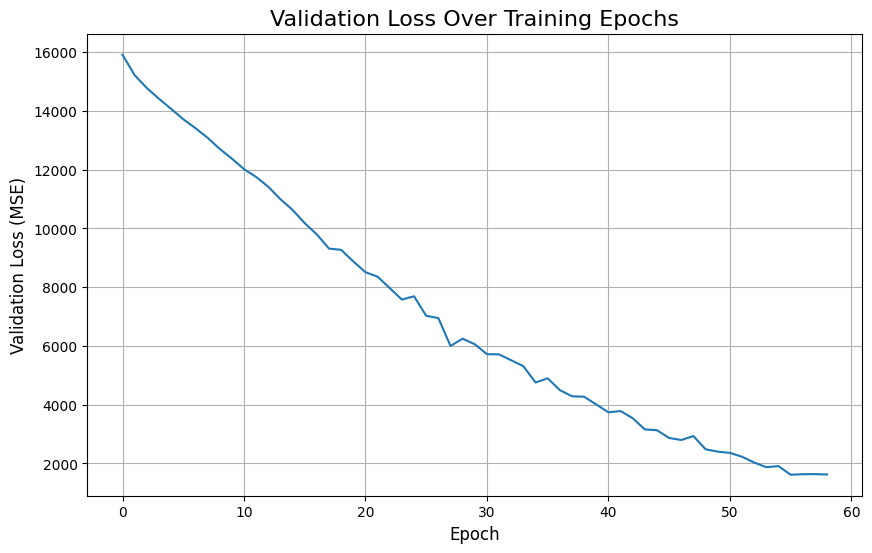

In [50]:

def get_scalar_data_from_tags(log_file, tags_to_extract):
    """
    Extracts scalar data for specific tags from a TensorFlow event file.
    """
    data = {tag: [] for tag in tags_to_extract}
    try:
        for event in tf.compat.v1.train.summary_iterator(log_file):
            for value in event.summary.value:
                if value.tag in tags_to_extract:
                    data[value.tag].append(value.simple_value)
    except Exception as e:
        print(f"Error reading log file: {e}")
        return None
    return data

# Path to the log file.
log_file_path = r"C:\Users\User\Desktop\Processed Data\Cardiac Processed\Logs2\lightning_logs\version_2\events.out.tfevents.1758602311.HomePC.35528.5"

# Extract the data for Val Loss and Epoch
tags_to_extract = ["Val Loss", "epoch"]
extracted_data = get_scalar_data_from_tags(log_file_path, tags_to_extract)

if extracted_data is None or not extracted_data["Val Loss"] or not extracted_data["epoch"]:
    print("No 'Val Loss' or 'epoch' data found. Please check the tags and log file.")
else:
    val_losses = extracted_data["Val Loss"]
    # Here is the fix: create a new list of epochs from 0 to the number of data points
    epochs = list(range(len(val_losses)))

    # Plotting the validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_losses)
    plt.title("Validation Loss Over Training Epochs", fontsize=16)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation Loss (MSE)", fontsize=12)
    plt.grid(True)
    plt.show()

This is MUCH better than the previous model (around 10x less error) meaning the model is much better at 'recognising' where the heart is on a chest Xray. Great! There are many ways I can work on this, but I simply wanted to do a proof of principle example, and show how changing the LR can dramatically improve performance. Going forwards I could do the following to make improvements to the model (and when I have some time, I will):

While I made some progress in reducing the error (around 10x less error) and showing how changing the LR can dramatically improve performance, I know I have a lot more I could do to make the model better.

Here is a plan of what I could do next to improve heart localisation:

Data and Augmentation
Gather More Data: I could focus on increasing the size of my training dataset to help my model generalise better to unseen X-rays.

Diversify Augmentation: I could experiment with advanced techniques like Elastic Deformations to mimic real-world image distortions. I could also introduce more variation in brightness and contrast (Intensity/Contrast Changes) to make my model robust against different machine settings.

Check Data Quality: I could review the existing heart bounding box annotations, especially for images that were challenging. Cleaning up noisy labels could be a fast way to reduce error.

Model Architecture and Loss Function
Upgrade the Base Model: I could try replacing my current backbone with a more powerful, pre-trained network like ResNet or EfficientNet.

Change the Loss Function: Instead of relying solely on MSE for bounding box coordinates, I could switch to a loss function that's a better fit for object localisation. I could test L1 (Mean Absolute Error), which is less sensitive to big outliers, or even implement IoU (Intersection over Union) Loss, as it directly measures the quality of the predicted box overlap.

Optimisation and Training
Since my initial LR change was effective, I could explore more advanced optimisation techniques:

Use an LR Scheduler: I could implement a Learning Rate Scheduler (e.g., in PyTorch's torch.optim.lr_scheduler) that automatically reduces the LR when the validation loss stops improving.

Try New Optimisers: I could experiment with modern optimisers like AdamW or RAdam to see if they offer a final performance boost over my current choice.

Add Regularisation: To fight potential overfitting, I could introduce techniques like adding Dropout layers or increasing the Weight Decay parameter in my optimiser.

Tune Other Hyperparameters: I could look into systematically tuning other settings besides the LR, specifically batch size, to ensure I'm getting the best performance from my current configuration.